# **UNICEF Indicator Data Warehouse** - SDMX REST API Web Service

In [299]:
# import necessary libraries 
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

Connecting to the UNICEFs data warehouse using the SDMX standard

In [300]:
endpoint = "https://sdmx.data.unicef.org/ws/public/sdmxapi/rest"

## **1. STEP: select a dataflow**

Dataflows contain a set of data within a common structure. So I first use the API to get a list of all those dataflows. 

This requires adding the following to the endpoint and providing the parameters for ```format```, ```detail``` and ```reference```. I chose to get the data in the **JSON format**, with **full detail** and **no references**. 

In [301]:
dataflow_endpoint = "/dataflow/all/all/latest"
dataflow_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [302]:
# get the response and checking the status code 
dataflow_response = requests.get(url=endpoint+dataflow_endpoint, params=dataflow_params)
print(dataflow_response.status_code)

# converting the response into JSON format, printing the response  
dataflows = dataflow_response.json()['data']['dataflows']
# uncomment the next line to see the complete response 
# pprint(dataflows)

200


In [303]:
# this prints out all the dataflows and their necessary keys
for dflow in dataflows:
    # getting the "id" will be necessary for the next API call
    print(f"name: {dflow['name']} - id: {dflow['id']} - agency-id: {dflow['agencyID']} - dataflow-version: {dflow['version']}")

name: Brazil Country Office - id: BRAZIL_CO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: Brazil SELO - id: BRAZIL_CO_SELO - agency-id: BRAZIL_CO - dataflow-version: 1.0
name: CAP 2030 - id: CAP2030 - agency-id: CAP2030 - dataflow-version: 1.0
name: Coundown 2030 - id: CD2030 - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage indicators - id: CDCOV - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - demographic indicators - id: CDDEM - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - drivers indicators - id: CDDRIVER - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - coverage - equiplot data - id: CDEQUIPLOT - agency-id: CD2030 - dataflow-version: 1.0
name: Countdown - tier 2 indicators - id: CDT2 - agency-id: CD2030 - dataflow-version: 1.0
name: CD2030 All - id: CONSOLIDATED - agency-id: CD2030 - dataflow-version: 1.0
name: EAPRO Cross Sector Indicators - id: DF_EAPRO_CROSS_SECTOR - agency-id: EAPRO - dataflow-version: 1.0
nam

I chose  ```name: Demography - id: DM - agency-id: UNICEF - dataflow-version: 1.0```  for further exploration.

To get hold of the actual data later, it's necessary to remember the select **dataflow name**, the **dataflow id**, the **id of the agency** and the **version of the chosen dataflow**. 

In [304]:
SELECTED_DFLOW = 'DEMOGRAPHY'
SELECTED_DFLOW_ID = 'DM'
SELECTED_AGENCY_ID = 'UNICEF'
SELECTED_DFLOW_VER = "1.0"

## **2. STEP: explore the structure of the selected dataflow**

This structure uses the Data Structure Definition (DSD) to achieve reusability between different dataflows. It contains the attributes and dimensions.  

A new addition to the endpoint, including the agency ID of the selected dataflow, must be made to get hold of the structure. The parameters that are sent with the API call stay the same.

In [305]:
structure_endpoint = f"/datastructure/{SELECTED_AGENCY_ID}/{SELECTED_DFLOW}/latest"
structure_params = {
    "format": "sdmx-json",
    "detail": "full",
    "reference": "none",
}

In [306]:
# get the response and checking the status code 
structure_response = requests.get(url=endpoint+structure_endpoint, params=structure_params)
print(dataflow_response.status_code)

# search for the structure of the selected dataflow 
selected_structure = structure_response.json()['data']['dataStructures'][0]

# display the structure in JSON format 
pprint(selected_structure)


200
{'agencyID': 'UNICEF',
 'dataStructureComponents': {'attributeList': {'attributes': [{'assignmentStatus': 'Conditional',
                                                               'attributeRelationship': {'primaryMeasure': 'OBS_VALUE'},
                                                               'conceptIdentity': 'urn:sdmx:org.sdmx.infomodel.conceptscheme.Concept=UNICEF:UNICEF_CONCEPTS(1.0).OBS_STATUS',
                                                               'id': 'OBS_STATUS',
                                                               'links': [{'hreflang': 'en',
                                                                          'rel': 'self',
                                                                          'type': 'dataattribute',
                                                                          'uri': 'https://raw.githubusercontent.com/sdmx-twg/sdmx-json/develop/structure-message/tools/schemas/1.0/sdmx-json-structure-schema.json',
    

Let's explore the attributes and dimensions that were contained in the API response at little bit more. The key to access those lists is the ```dataStructureComponents``` key.

In [307]:
datastructure_comp = selected_structure['dataStructureComponents']

### Dimensions

In [308]:
# get the dimensions
dimensions_json = datastructure_comp['dimensionList']

dimensions = [(dim['id'], dim['position']) for dim in dimensions_json['dimensions']]
print(dimensions)

time_dimensions = [(tdim['id'],tdim['position']) for tdim in dimensions_json['timeDimensions']]
print(time_dimensions)

[('REF_AREA', 1), ('INDICATOR', 2), ('RESIDENCE', 3), ('SEX', 4), ('AGE', 5)]
[('TIME_PERIOD', 6)]


The ```dataStructureComponents``` for the Demography dataflow includes **6 dimensions total**, with the ```TIME_PERIOD``` in its own category of ```timeDimensions```. The positions at the second position in the tuple are required when making queries for specific data slices later. 

### Attributes

In [309]:
# get the attributes
attributes_json = datastructure_comp['attributeList']
attributes = attributes_json['attributes']

for att in attributes:
    print(f"{att['id']} - relation: {att['attributeRelationship']}")

OBS_STATUS - relation: {'primaryMeasure': 'OBS_VALUE'}
OBS_CONF - relation: {'primaryMeasure': 'OBS_VALUE'}
DATA_SOURCE - relation: {'primaryMeasure': 'OBS_VALUE'}
UNIT_MEASURE - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
UNIT_MULTIPLIER - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
COVERAGE_TIME - relation: {'primaryMeasure': 'OBS_VALUE'}
FREQ_COLL - relation: {'primaryMeasure': 'OBS_VALUE'}
SOURCE_LINK - relation: {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']}
TIME_PERIOD_METHOD - relation: {'primaryMeasure': 'OBS_VALUE'}
SERIES_FOOTNOTE - relation: {'dimensions': ['INDICATOR']}
OBS_FOOTNOTE - relation: {'primaryMeasure': 'OBS_VALUE'}


There are **11 different attributes** that can be attached to a data point in the Demography dataflow. Attributes can relate to the dimensions or to the ```primaryMeasure``` which in this case is the observation value ```OBS_VALUE```. The screenshot below shows the observation details from the Demography dataflow displayed in the Data Browser to have an example of the use case of those parameters. 

The chosen dimensions are displayed on the left, and the attached attributes are on the right. 

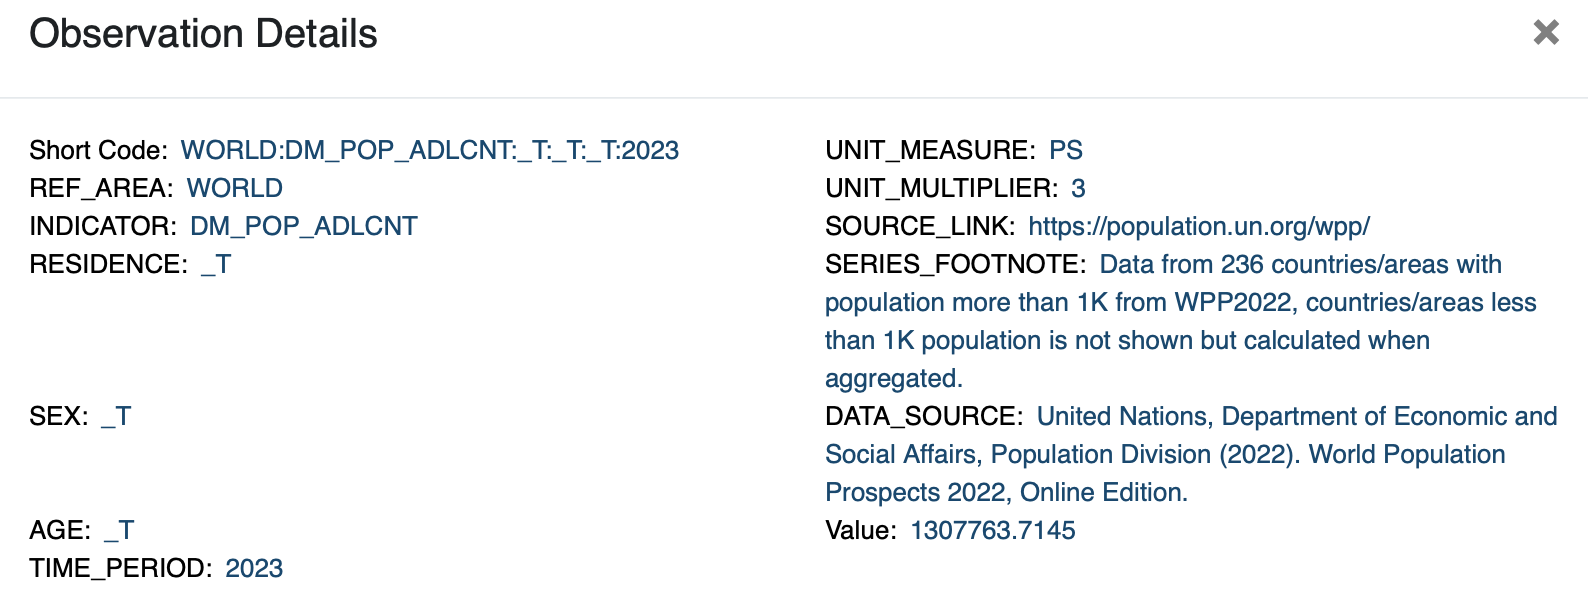


## **3. STEP: getting hold of the actual data**

To do this, the following modified string has to be added to the endpoint.

In [310]:
complete_data_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/all"
complete_data_params = {
    "format": "sdmx-json"
}

This would get hold of the complete dataset within this chosen dataflow and version, but it's also possible to get just a piece of this dataset.

This would get hold of the complete dataset within this chosen dataflow and version, but it's also possible to get just a piece of this dataset.

Getting just a slice of the data is possible by specifying specific values for the dimensions. Let's say we want to select the following:

- for the ```REF_AREA``` **Western Europe**
- for the ```INDICATOR``` **everything**
- for the ```RESIDENCE``` **just the total**
- for the ```SEX``` **just the total**
- for the ```AGE``` **everything**

The possible values for those dimensions can be found in the **codelist** for this dataflow. To get hold of this codelist, another API call is necessary. The string that has to be added to the endpoint is the same as for getting the complete data, but with the parameters, the ```detail``` is limited to ```structureOnly```.

In [311]:
codelist_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/all"
codelist_params = {
    "format": "sdmx-json",
    "detail": "structureOnly"
}

In [334]:
# get the response and checking the status code 
codelist_response = requests.get(url=endpoint+codelist_endpoint, params=codelist_params)
print(codelist_response.status_code)

codelist = codelist_response.json()['structure']['dimensions']['observation']
# uncomment next line to print codelist
# pprint(codelist)

200


The following picture is a screenshot from the codelist returned from the API call. The codelist provides a list of all the dimensions and all possible ```values``` for them. Because I wanted to limited the ```REF_AREA```, ```RESIDENCE``` and ```SEX``` let's look at the possible values for those: 


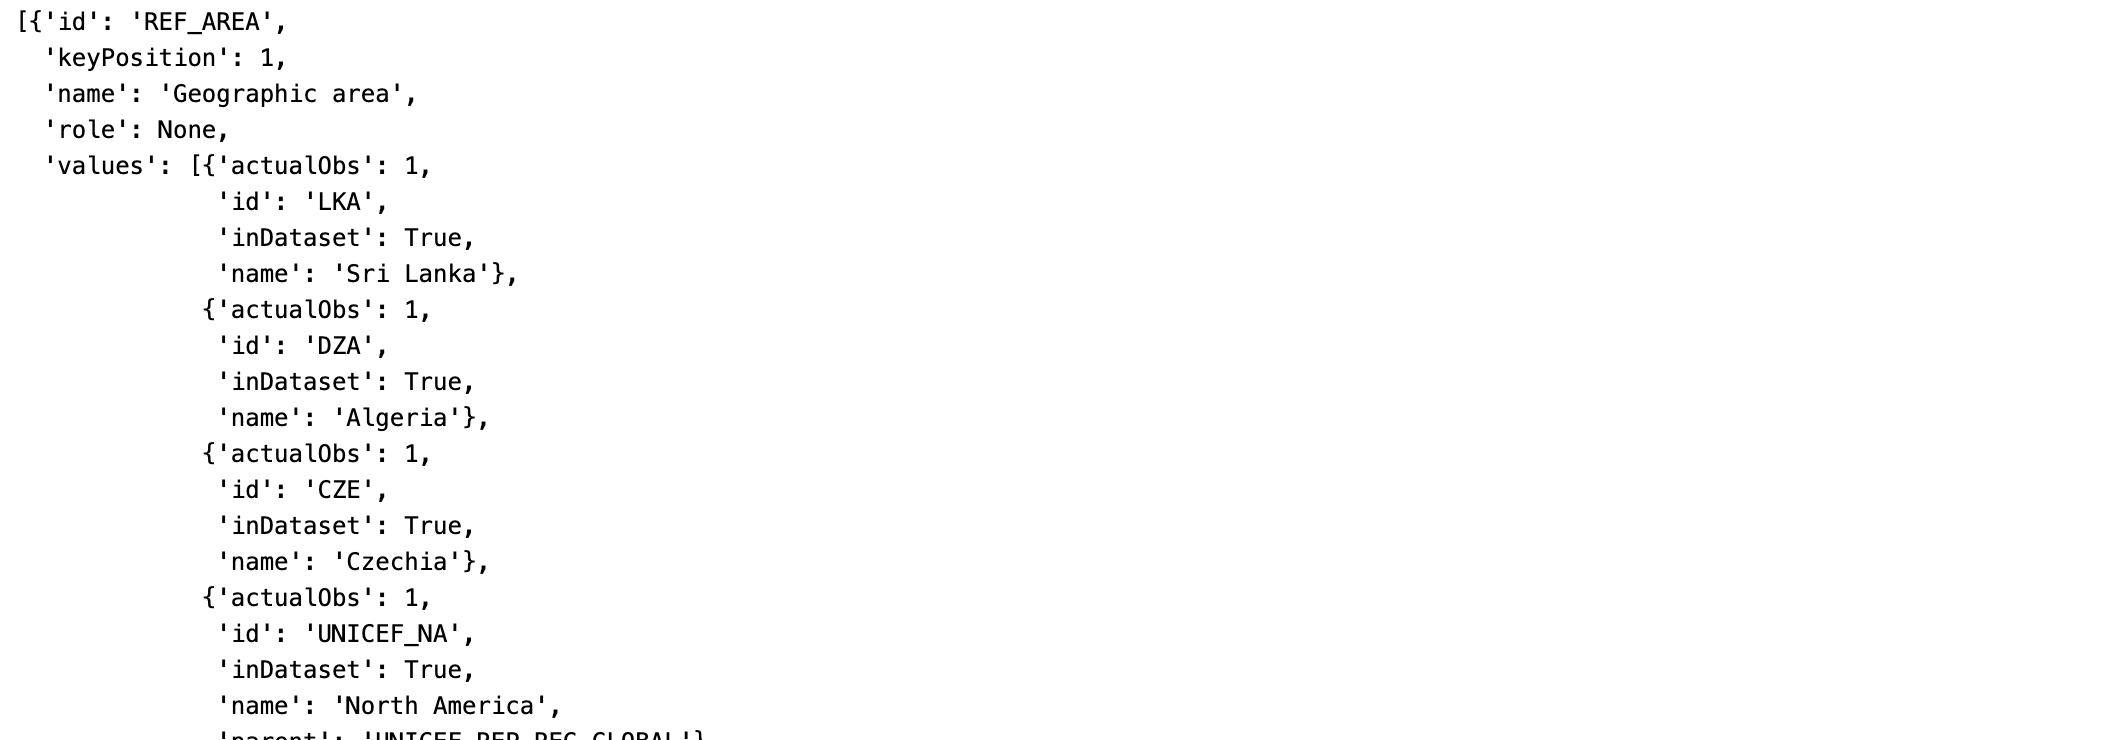

Looking for the ```REF_AREA``` to select only Western Europe. The order of dimensions will be the same as before; therefore, I know that the ```REF_AREA``` will be the first dimension in the list.

In [350]:
ref_area_values = [(v['name'], v['id']) for v in codelist[0]['values']]   
# this prints a list of tuples containing the name of the country or region and the id 
print(ref_area_values)

# search for the id of Western Europe
west_eu_id = [i for (n, i) in ref_area_values if n == "Western Europe"]
print(f"ID of Western Europe: {west_eu_id[0]}")


[('Sri Lanka', 'LKA'), ('Algeria', 'DZA'), ('Czechia', 'CZE'), ('North America', 'UNICEF_NA'), ('Jordan', 'JOR'), ('Trinidad and Tobago', 'TTO'), ('Spain', 'ESP'), ('Afghanistan', 'AFG'), ('Eswatini', 'SWZ'), ('South Asia', 'UNICEF_ROSA'), ("Lao People's Democratic Republic", 'LAO'), ('Türkiye', 'TUR'), ('Europe and Central Asia', 'UNICEF_ECARO'), ('Bosnia and Herzegovina', 'BIH'), ('Grenada', 'GRD'), ('Virgin Islands U.S.', 'VIR'), ('Greece', 'GRC'), ('Niue', 'NIU'), ('Saint Barthélemy', 'BLM'), ('Italy', 'ITA'), ('Switzerland', 'CHE'), ('Dominican Republic', 'DOM'), ('Bangladesh', 'BGD'), ('Cabo Verde', 'CPV'), ('Gabon', 'GAB'), ('Lesotho', 'LSO'), ('Saint Pierre and Miquelon', 'SPM'), ('Belarus', 'BLR'), ('Rwanda', 'RWA'), ('Isle of Man', 'IMN'), ('Eritrea', 'ERI'), ('Germany', 'DEU'), ('Luxembourg', 'LUX'), ('Estonia', 'EST'), ('New Caledonia', 'NCL'), ('Guatemala', 'GTM'), ('Somalia', 'SOM'), ('Bermuda', 'BMU'), ('French Guiana', 'GUF'), ('Mauritius', 'MUS'), ('Mayotte', 'MYT'), (

Next let's get the value for ```RESIDENCE``` which should be third in the list:

In [352]:
residence_values = [(v['name'], v['id']) for v in codelist[2]['values']]
print(residence_values)

[('Total', '_T')]


And at last the value for ```SEX``` which should be fourth: 

In [354]:
sex_values = [(v['name'], v['id']) for v in codelist[3]['values']]
print(sex_values)

[('Female', 'F'), ('Total', '_T'), ('Male', 'M')]


Now those dimension values can be used in the query string:

- select **Western Europe** as reference area: ```UNICEF_WE```
- select **all residencies**: ```_T```
- select **all genders**: ```_T```

Those parameters have to be added to the endpoint string **separated by dots**. Multiple values for a dimension should be separated by a "+". 

**Important**: The query string has to contain every dimension. If nothing should be specified, it has to be treated like being left out by just typing the next separating dot. The order is the same as in the dimensions list shown above or as specified under their ```keyPosition``` attribute. 

**REF_AREA.~~INDICATOR~~.RESIDENCE.SEX.~~AGE~~** -> final string: **UNICEF_WE.._T._T.**

In [313]:
QUERY_STR = "UNICEF_WE.._T._T."

In [314]:
data_endpoint = f"/data/{SELECTED_AGENCY_ID},{SELECTED_DFLOW_ID},{SELECTED_DFLOW_VER}/{QUERY_STR}"
data_params = {
    "format": "sdmx-json",
}

In [315]:
# get the response
data_response = requests.get(url=endpoint+data_endpoint, params=data_params).json()['data']

for list in data_response:
    print(list)

dataSets
structure


After retrieving the response in the JSON format, it's necessary to **connect the actual values with their corresponding dimensions and attributes**. Those are separated in ```structure``` and ```dataSets```.

Let's first look into the ```structure```:

Using the ```dimensions``` key, we find two further keys: ```series``` which contains the **dimensions 1 to 5** and ```observation``` which contains **dimension number 6**, the ```TIME_PERIOD```.

In [316]:
dim_response = data_response['structure']['dimensions']['series']
pprint(dim_response)

[{'id': 'REF_AREA',
  'keyPosition': 0,
  'name': 'Geographic area',
  'role': None,
  'values': [{'id': 'UNICEF_WE', 'name': 'Western Europe'}]},
 {'id': 'INDICATOR',
  'keyPosition': 1,
  'name': 'Indicator',
  'role': None,
  'values': [{'description': 'Total population',
              'id': 'DM_POP_TOT',
              'name': 'Total population'},
             {'description': 'Population under age 18',
              'id': 'DM_POP_U18',
              'name': 'Population under age 18'},
             {'description': 'Population under age 5',
              'id': 'DM_POP_U5',
              'name': 'Population under age 5'},
             {'description': 'Adolescent population aged 10-19',
              'id': 'DM_POP_ADLCNT',
              'name': 'Adolescent population (10-19)'},
             {'id': 'DM_POP_15TO24', 'name': 'Youth population from 15 to 24'},
             {'description': 'Average exponential rate of growth of the '
                             'population over one year',
 

In [317]:
obs_dim_response = data_response['structure']['dimensions']['observation']
pprint(obs_dim_response)

[{'id': 'TIME_PERIOD',
  'keyPosition': 5,
  'name': 'Time period',
  'role': 'time',
  'values': [{'end': '1950-12-31T23:59:59',
              'id': '1950',
              'name': '1950',
              'start': '1950-01-01T00:00:00'},
             {'end': '1951-12-31T23:59:59',
              'id': '1951',
              'name': '1951',
              'start': '1951-01-01T00:00:00'},
             {'end': '1952-12-31T23:59:59',
              'id': '1952',
              'name': '1952',
              'start': '1952-01-01T00:00:00'},
             {'end': '1953-12-31T23:59:59',
              'id': '1953',
              'name': '1953',
              'start': '1953-01-01T00:00:00'},
             {'end': '1954-12-31T23:59:59',
              'id': '1954',
              'name': '1954',
              'start': '1954-01-01T00:00:00'},
             {'end': '1955-12-31T23:59:59',
              'id': '1955',
              'name': '1955',
              'start': '1955-01-01T00:00:00'},
             {'end':

Looking at those dimensions from the response, we can see the ```TIME_PERIOD``` which goes from 1950 to 2023, the ```REF_AREA``` which I limited to only return values for ```UNICEF_WE``` ('Western Europe'), all those different values for the ```INDICATOR```, and the ```RESIDENCE```, ```SEX``` and ```AGE``` all limited to 'Total'.

Next, let's get an overview of the attributes, which are also split into ```series``` and ```observation```. 

The difference is that the attributes under ```observation``` are all related to the ```OBS_VALUE``` and the attributes under ```series``` to the dimensions.

In [318]:
attr_response = data_response['structure']['attributes']['series']
pprint(attr_response)

[{'id': 'UNIT_MEASURE',
  'name': 'Unit of measure',
  'relationship': {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']},
  'role': None,
  'values': [{'id': 'PS', 'name': 'Persons'},
             {'id': 'PCNT', 'name': '%'},
             {'id': 'NUMBER', 'name': 'Number'},
             {'id': 'YR', 'name': 'Years'}]},
 {'id': 'UNIT_MULTIPLIER',
  'name': 'Unit multiplier',
  'relationship': {'dimensions': ['REF_AREA', 'RESIDENCE', 'SEX', 'AGE']},
  'role': None,
  'values': [{'description': 'In scientific notation, expressed as ten raised '
                             'to the power of three (10^3)',
              'id': '3',
              'name': 'Thousands'},
             {'description': 'In scientific notation, expressed as ten raised '
                             'to the power of zero (10^0)',
              'id': '0',
              'name': 'Units'}]},
 {'id': 'SOURCE_LINK',
  'name': 'Citation of or link to the data source',
  'relationship': {'dimensions': ['REF_AREA', 'RES

In [319]:
obs_attr_response = data_response['structure']['attributes']['observation']
pprint(obs_attr_response)

[{'id': 'OBS_STATUS',
  'name': 'Observation Status',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': []},
 {'id': 'OBS_CONF',
  'name': 'Observation confidentaility',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': []},
 {'id': 'DATA_SOURCE',
  'name': 'Data Source',
  'relationship': {'primaryMeasure': 'OBS_VALUE'},
  'role': None,
  'values': [{'id': 'United Nations, Department of Economic and Social '
                    'Affairs, Population Division (2022). World Population '
                    'Prospects 2022, Online Edition.',
              'name': 'United Nations, Department of Economic and Social '
                      'Affairs, Population Division (2022). World Population '
                      'Prospects 2022, Online Edition.'},
             {'id': 'United Nations, Department of Economic and Social '
                    'Affairs, Population Division (2018). World Urbanization '
                    'Prospects: T

Now it's time to retrieve the actual data points:

In [320]:
dpoints_response = data_response['dataSets']
# to view uncomment the next line
# pprint(dpoints_response)

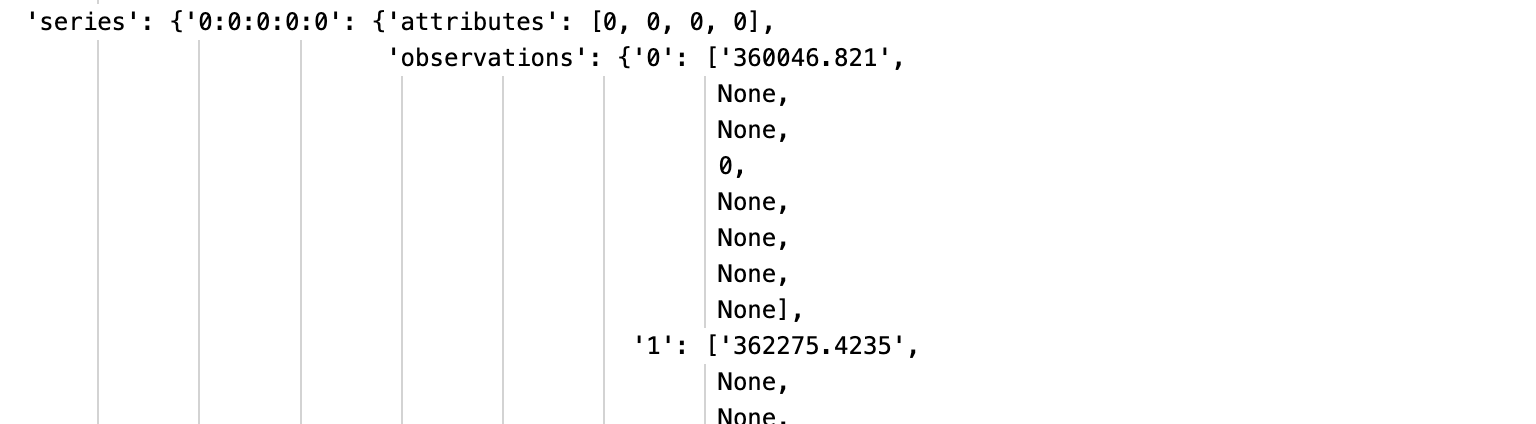

Each data point is **identified by a key consisting out of 5 numbers** (in this specific example) separated by colon. **Those numbers represent the different dimensions**. In this case only the second number changes because that's the number corresponding with the ```INDICATOR```.

In [321]:
# get the different keys of the data points and their corresponding dimensions  
for point in dpoints_response[0]['series']:
    print(f"{point} - "
          f"{dim_response[0]['values'][int(point.split(':')[0])]['name']} : "
          f"{dim_response[1]['values'][int(point.split(':')[1])]['name']} : "
          f"{dim_response[2]['values'][int(point.split(':')[2])]['name']} : "
          f"{dim_response[3]['values'][int(point.split(':')[3])]['name']} : "
          f"{dim_response[4]['values'][int(point.split(':')[4])]['name']}")

0:0:0:0:0 - Western Europe : Total population : Total : Total : Total
0:1:0:0:0 - Western Europe : Population under age 18 : Total : Total : Total
0:2:0:0:0 - Western Europe : Population under age 5 : Total : Total : Total
0:3:0:0:0 - Western Europe : Adolescent population (10-19) : Total : Total : Total
0:4:0:0:0 - Western Europe : Youth population from 15 to 24 : Total : Total : Total
0:5:0:0:0 - Western Europe : Population annual growth rate : Total : Total : Total
0:6:0:0:0 - Western Europe : Number of births : Total : Total : Total
0:7:0:0:0 - Western Europe : Total fertility rate : Total : Total : Total
0:8:0:0:0 - Western Europe : Life expectancy : Total : Total : Total
0:9:0:0:0 - Western Europe : Total dependency ratio : Total : Total : Total
0:10:0:0:0 - Western Europe : Child dependency ratio : Total : Total : Total
0:11:0:0:0 - Western Europe : Old age dependency ratio : Total : Total : Total
0:12:0:0:0 - Western Europe : Share of urban population : Total : Total : Total
0:

Next is the key ```attributes``` which contains a list with numbers corresponding with the attributes. Let's use the first data point from the screenshot above as example: ```'attributes': [0, 0, 0, 0]```

In [322]:
example = dpoints_response[0]['series']['0:0:0:0:0']

In [323]:
for i, v in enumerate(example['attributes']):
    print(f"{attr_response[i]['id']}: {v} -> {attr_response[i]['values'][v]['name']}")

UNIT_MEASURE: 0 -> Persons
UNIT_MULTIPLIER: 0 -> Thousands
SOURCE_LINK: 0 -> https://population.un.org/wpp/
SERIES_FOOTNOTE: 0 -> Data from 236 countries/areas with population more than 1K from WPP2022, countries/areas less than 1K population is not shown but calculated when aggregated.


Now it finally time to deal with the observations:

```'observations': {'0': ['360046.821', None, None, 0, None, None, None, None],}```

The first number gives a the place of the entry in the observations that were contained in the dimensions key. So in this case the ```TIME_PERIOD```.

The following list starts with the ```OBS_VALUE``` which was listed in the structure under ```primaryMeasure```. The other values are corresponding with the observations that were contained in the attributes key. 

In [324]:
print(f"'0' -> TIME_PERIOD: {obs_dim_response[0]['values'][0]['name']}")

'0' -> TIME_PERIOD: 1950


In [325]:
obs_attr_response[0]

{'id': 'OBS_STATUS',
 'name': 'Observation Status',
 'relationship': {'primaryMeasure': 'OBS_VALUE'},
 'role': None,
 'values': []}

In [326]:
for i, v in enumerate(example['observations']['0']):
    if i == 0: 
        print(f"OBS_VALUE: {v}\n")
    else:
        print(f"{obs_attr_response[i-1]['name']}: {v}")

OBS_VALUE: 360046.821

Observation Status: None
Observation confidentaility: None
Data Source: 0
The period of time for which data are provided: None
Time interval at which the source data are collected: None
Time period activity related to when the data are collected: None
Observation footnote: None


## **4. STEP: explore data**

Let's explore how the number of births in Western Europe changed over the years. To do this I'll first create a DataFrame with all the useful values. 

In [327]:
# create a dictionary which will be converted into a pandas DataFrame later
data = {}

# going over all those dimension keys 
for k, v in dpoints_response[0]['series'].items():
    # because only the 'INDICATOR' changes I will only keep that 
    indicator_index = int(k.split(':')[1])

    # this will get the 'id' of the corresponding value in the 'INDICATOR' dimension 
    # this id will be used as column later and therefore used as a key in the new dict 
    indicator_key = dim_response[1]['values'][indicator_index]['id']

    # to get the values I'll loop over the different keys for the observation dimension corresponding with the 'TIME_PERIOD'
    # I'll only use the observation values and put them into a consecutive list 
    # later the years will be used a indices 
    indicator_values = []
    for i, v in enumerate(obs_dim_response[0]['values']):
        try: 
            indicator_values.append(dpoints_response[0]['series'][k]['observations'][str(i)][0])
        except KeyError:
            indicator_values.append(None)
    
    # put everything together 
    data[indicator_key] = indicator_values

print(data)


{'DM_POP_TOT': ['360046.821', '362275.4235', '364615.6255', '367236.9075', '369958.3805', '372647.2225', '375280.3495', '377958.374', '380877.269', '383924.0725', '386932.4745', '390053.8575', '393287.6465', '396502.2875', '399858.8165', '403165.982', '406302.0965', '409355.0465', '412150.778', '414640.9005', '416909.4875', '419295.613', '421868.879', '424262.833', '426507.1465', '428512.642', '430249.785', '431967.585', '433614.523', '435202.746', '436910.7285', '438522.5615', '439902.19', '441154.3725', '442378.2025', '443621.7565', '444878.1335', '446241.4085', '447676.3405', '449124.0425', '450612.051', '452198.8625', '453827.579', '455306.01', '456599.9255', '457743.3515', '458779.5985', '459809.941', '460814.1455', '461796.773', '463032.85', '464362.7675', '465891.093', '467843.811', '470007.2145', '472199.0885', '474373.821', '476884.1735', '479478.533', '481663.224', '483558.998', '485321.516', '486845.1985', '488064.7255', '489231.7235', '490441.161', '491694.204', '492993.99'

In [328]:
# create indices list for the DataFrame with years from 'TIME_PERIOD' dimension 
indices = [int(obs_dim_response[0]['values'][i]['id']) for i, v in enumerate(obs_dim_response[0]['values'])]

# create the DataFrame
df = pd.DataFrame(data, index=indices)

df

,DM_POP_TOT,DM_POP_U18,DM_POP_U5,DM_POP_ADLCNT,DM_POP_15TO24,DM_POP_GRT,DM_BRTS,DM_FRATE_TOT,DM_LIFE_EXP,DM_DPR_TOT,DM_DPR_CHD,DM_DPR_OLD,DM_POP_URBN,DM_POP_U_GRT,DM_NET_MG_RATE,DM_POP_ADLCNT_PROP
1950,360046.821,107355.514,32727.9435,57839.9075,57355.14,None,7101.272,2.57,65.361,51.65,37.991,13.66,59.3959823573379,None,-2.377,16.0645516434098
1951,362275.4235,107823.663,33117.8155,57571.1155,57110.789,None,6973.249,2.527,65.384,51.789,37.949,13.84,59.7887543033316,None,-1.667,15.8915321784172
1952,364615.6255,108357.641,33085.907,57211.0155,56878.8765,None,6943.765,2.52,66.47,51.992,37.966,14.026,60.1593468440138,None,-1.453,15.690774475599
1953,367236.9075,108875.453,32938.71,57023.892,56695.9235,None,6916.519,2.51,66.937,52.209,37.981,14.228,60.5260440876617,None,-0.364,15.5278216419464
1954,369958.3805,109474.391,32795.505,57007.0285,56595.2495,None,6941.175,2.517,67.576,52.407,37.994,14.413,60.8996163003978,None,-0.952,15.4090382877541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,495570.3535,91995.246,24501.4595,52123.39,53299.615,None,4665.521,1.529,81.682,55.415,24.049,31.366,76.9075535931274,None,3.111,10.5178587927778
2020,496404.869,91865.2495,24184.9285,52382.6215,53203.9685,0.0498989682487103,4574.469,1.509,80.896,55.926,24.018,31.908,77.1303415010454,0.329643641470482,2.393,10.5523988121881
2021,496711.423,91635.042,23795.257,52619.2145,53158.902,None,4570.015,1.52,80.858,56.366,23.949,32.417,77.3604290282091,None,2.382,10.5935180999451
2022,499090.7275,91608.558,23515.632,53109.3535,53762.6375,None,4543.124,1.523,81.643,56.585,23.77,32.815,77.5230113014714,None,10.363,10.6412222415012


In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 1950 to 2023
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DM_POP_TOT          74 non-null     object
 1   DM_POP_U18          74 non-null     object
 2   DM_POP_U5           74 non-null     object
 3   DM_POP_ADLCNT       74 non-null     object
 4   DM_POP_15TO24       74 non-null     object
 5   DM_POP_GRT          2 non-null      object
 6   DM_BRTS             74 non-null     object
 7   DM_FRATE_TOT        74 non-null     object
 8   DM_LIFE_EXP         74 non-null     object
 9   DM_DPR_TOT          74 non-null     object
 10  DM_DPR_CHD          74 non-null     object
 11  DM_DPR_OLD          74 non-null     object
 12  DM_POP_URBN         74 non-null     object
 13  DM_POP_U_GRT        2 non-null      object
 14  DM_NET_MG_RATE      74 non-null     object
 15  DM_POP_ADLCNT_PROP  74 non-null     object
dtypes: object(16)
memory usage: 

Because all those values were treated as if they were strings the Dtypes are objects. This has to be changed in order to work with them as numerical values. I will also drop the ```DM_POP_GRT``` and ```DM_POP_U_GRT``` because they only contain 2 NaN values which is not very useful for time comparison. 

In [330]:
# drop columns with only 2 NaN values 
df.drop(columns=['DM_POP_GRT', 'DM_POP_U_GRT'], axis=1, inplace=True)

In [331]:
# change Dtypes 
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 1950 to 2023
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DM_POP_TOT          74 non-null     float64
 1   DM_POP_U18          74 non-null     float64
 2   DM_POP_U5           74 non-null     float64
 3   DM_POP_ADLCNT       74 non-null     float64
 4   DM_POP_15TO24       74 non-null     float64
 5   DM_BRTS             74 non-null     float64
 6   DM_FRATE_TOT        74 non-null     float64
 7   DM_LIFE_EXP         74 non-null     float64
 8   DM_DPR_TOT          74 non-null     float64
 9   DM_DPR_CHD          74 non-null     float64
 10  DM_DPR_OLD          74 non-null     float64
 11  DM_POP_URBN         74 non-null     float64
 12  DM_NET_MG_RATE      74 non-null     float64
 13  DM_POP_ADLCNT_PROP  74 non-null     float64
dtypes: float64(14)
memory usage: 8.7 KB


Now I it's possible to explore how the number of births in Western Europe changed over the years. 

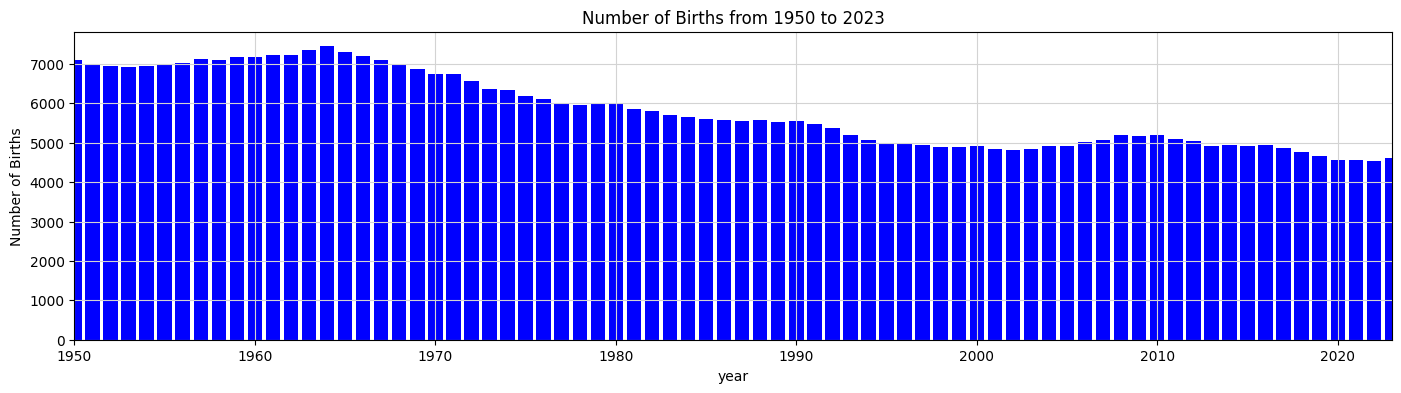

In [332]:
fig, ax = plt.subplots(figsize=(17,4))
plt.bar(
    x=df.index,
    height=df['DM_BRTS'],
    color='blue'
)

ax.grid(True, color="lightgrey")
plt.title('Number of Births from 1950 to 2023')
plt.ylabel('Number of Births')
plt.xlabel('year')
plt.xlim(1950, 2023)

plt.show()

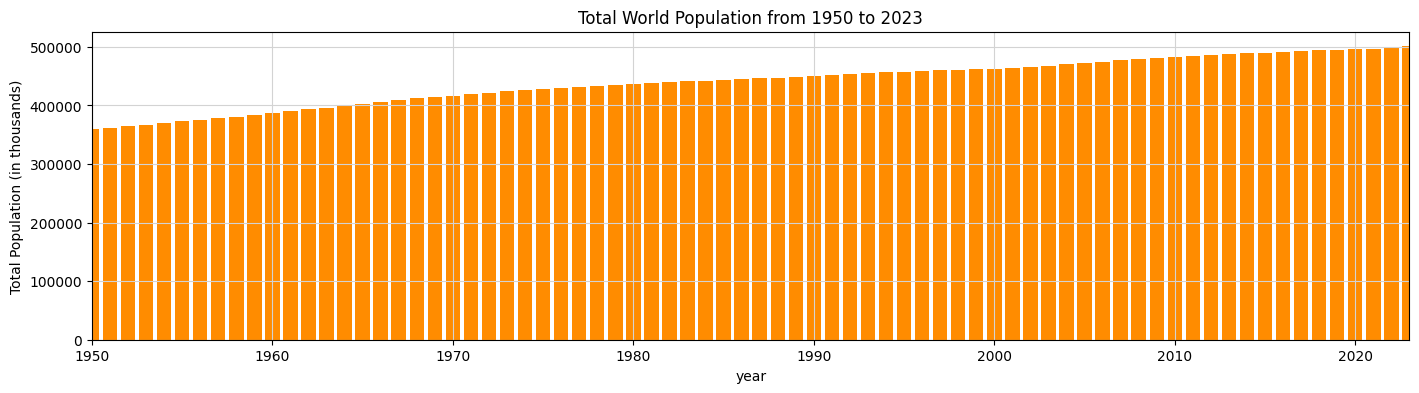

In [333]:
fig, ax = plt.subplots(figsize=(17,4))
plt.bar(
    x=df.index,
    height=df['DM_POP_TOT'], 
    color='darkorange'
)

ax.grid(True, color="lightgrey")
plt.title('Total World Population from 1950 to 2023')
plt.ylabel('Total Population (in thousands)')
plt.xlabel('year')
plt.xlim((1950, 2023))


plt.show()